# Compute metrics on data using stratification 

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os

In [5]:
temperature_data = pd.read_csv('simulation_results/clean_data/all_temperatures.csv')

(array([  2.,   2.,   0.,   2.,   1.,   2.,   0.,   2.,   0.,   1.,   2.,
          4.,   5.,   3.,   7.,   4.,   2.,   6.,   6.,   6.,   1.,   7.,
          4.,   2.,   5.,   4.,   9.,   5.,  16.,  12.,   8.,  17.,  10.,
          6.,  13.,  26.,  37.,  19.,  37.,  28.,  44.,  31.,  45.,  56.,
         33.,  67.,  28.,  85.,  37.,  92.,  92.,  33., 102.,  52., 112.,
         58., 137., 118.,  64., 122.,  57., 109.,  33.,  91., 117.,  56.,
        112.,  56., 136.,  53., 107.,  98.,  48.,  89.,  48.,  79.,  45.,
         89.,  63.,  24.,  57.,  28.,  65.,  31.,  64.,  67.,  23.,  49.,
         27.,  67.,  24.,  63.,  61.,  25.,  50.,  24.,  65.,  36.,  68.,
         48.,  67.,  60.,  34.,  86.,  28.,  68.,  34.,  71.,  57.,  32.,
         62.,  36.,  72.,  46.,  66.,  76.,  38.,  65.,  39.,  66.,  34.,
         73.,  80.,  28.,  64.,  41.,  59.,  21.,  59.,  68.,  25.,  65.,
         31.,  57.,  33.,  47.,  53.,  23.,  49.,  29.,  51.,  25.,  52.,
         28.,  20.,  34.,  21.,  34., 

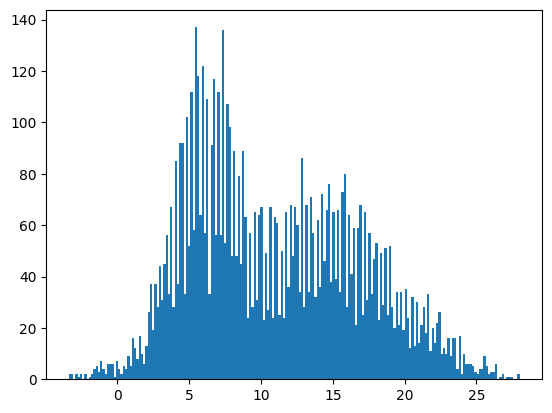

In [6]:
plt.hist(temperature_data['temp'], bins=200)

In [58]:

# divide in quantiles
temperature_data['quantile'] = pd.qcut(temperature_data['temp'], 
                                        q=11)

quantile_bins = temperature_data['quantile'].cat.categories



In [52]:
from src.data_loader import load_data
from src.metrics import *

results_pid_nominal = load_data('pid', 'nominal')
results_pid_with_noise = load_data('pid', 'noise')
results_pid_with_disturbances = load_data('pid', 'disturbances')

results_onoff_nominal = load_data('onoff', 'nominal')
results_onoff_with_noise = load_data('onoff', 'noise')
results_onoff_with_disturbances = load_data('onoff', 'disturbances')

results_fuzzy_nominal = load_data('fuzzy', 'nominal')
results_fuzzy_with_noise = load_data('fuzzy', 'noise')
results_fuzzy_with_disturbances = load_data('fuzzy', 'disturbances')

metrics = [steady_state_error, mean_square_error, overshoot, comfort_time, 
            energy_consumed]

results = {
    "results_pid_nominal": results_pid_nominal,
    "results_pid_with_noise": results_pid_with_noise,
    "results_pid_with_disturbances": results_pid_with_disturbances,
     "results_onoff_nominal": results_onoff_nominal,
     "results_onoff_with_noise": results_onoff_with_noise,
     "results_onoff_with_disturbances": results_onoff_with_disturbances,
     "results_fuzzy_nominal": results_fuzzy_nominal,
     "results_fuzzy_with_noise": results_fuzzy_with_noise,
     "results_fuzzy_with_disturbances": results_fuzzy_with_disturbances,
}

KeyboardInterrupt: 

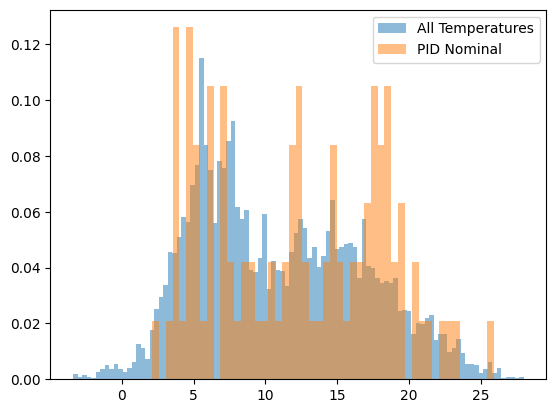

In [9]:
plt.hist(temperature_data['temp'], bins=100, alpha=0.5, label='All Temperatures', density=True)
outsideTemp =  [df['outsideTemp'].iloc[0] for df in results_pid_nominal]
#outsideTemp = pd.concat(outsideTemp, ignore_index=True)
plt.hist(outsideTemp, bins=50, alpha=0.5, label='PID Nominal', density=True)

plt.legend()

In [59]:


def precompute_metric_values(scenario_results, metric_fn):
    """Precompute the metric value for each simulation"""
    return [
        {
            'df': df,
            'initial_temp': df['outsideTemp'].iloc[0],
            'value': metric_fn(df, 'temperatureSensor_T', 20.0, 'windowState')
        }
        for df in scenario_results
    ]


def stratify(precomputed, quantile_bins):
    """Stratify precomputed results by initial temperature"""
    temps = [entry['initial_temp'] for entry in precomputed]
    labels = pd.cut(temps, bins=quantile_bins)
    strata = {}

    for entry, label in zip(precomputed, labels):
        strata.setdefault(label, []).append(entry['value'])

    return strata


def stratified_bootstrap_ci(precomputed, quantile_bins, num_samples=1000, confidence=0.95):
    strata = stratify(precomputed, quantile_bins)
    combined_means = []

    for _ in range(num_samples):
        print(f"Bootstrap iteration {_ + 1}/{num_samples}")
        stratum_means = []
        for values in strata.values():
            if not values:
                continue
            resampled = random.choices(values, k=len(values))
            stratum_means.append(np.mean(resampled))
        combined_means.append(np.mean(stratum_means))

    lower = np.percentile(combined_means, (1 - confidence) / 2 * 100)
    upper = np.percentile(combined_means, (1 + confidence) / 2 * 100)
    mean = np.mean(combined_means)
    return mean, lower, upper


def stratified_bootstrap_variance_ci(precomputed, quantile_bins, num_samples=1000, confidence=0.95):
    strata = stratify(precomputed, quantile_bins)
    combined_variances = []

    for _ in range(num_samples):
        stratum_means = []
        for values in strata.values():
            if not values:
                continue
            resampled = random.choices(values, k=len(values))
            stratum_means.append(np.mean(resampled))
        combined_variances.append(np.var(stratum_means, ddof=1))

    lower = np.percentile(combined_variances, (1 - confidence) / 2 * 100)
    upper = np.percentile(combined_variances, (1 + confidence) / 2 * 100)
    var = np.mean(combined_variances)
    return var, lower, upper


def calculate_and_export_stats(scenario_results, metrics, scenario_name):
    aggregated_stats = []
    long_format_records = []

    for metric in metrics:
        # 1. Precompute values only once
        precomputed = precompute_metric_values(scenario_results, metric)

        # 2. Confidence intervals using precomputed values
        mean, mean_ci_lower, mean_ci_upper = stratified_bootstrap_ci(precomputed, quantile_bins)
        var, var_ci_lower, var_ci_upper = stratified_bootstrap_variance_ci(precomputed, quantile_bins)

        # 3. Store overall results
        aggregated_stats.append({
            'metric': metric.__name__,
            'mean': mean,
            'mean_ci_lower': mean_ci_lower,
            'mean_ci_upper': mean_ci_upper,
            'var': var,
            'var_ci_lower': var_ci_lower,
            'var_ci_upper': var_ci_upper
        })

        # 4. Export per-simulation values
        for i, entry in enumerate(precomputed):
            long_format_records.append({
                'controller': scenario_name,
                'run': i,
                'metric': metric.__name__,
                'value': entry['value']
            })

    # Export results
    pd.DataFrame(aggregated_stats).to_csv(f"simulation_results/statistics/{scenario_name}_aggregated_low_var.csv", index=False)
    pd.DataFrame(long_format_records).to_csv(f"simulation_results/statistics/{scenario_name}_all_low_var.csv", index=False)


In [60]:
for name, scenario in results.items():
    calculate_and_export_stats(scenario, metrics, scenario_name=name)
    print(f"Stats for {name} calculated and exported.")


Bootstrap iteration 1/1000
Bootstrap iteration 2/1000
Bootstrap iteration 3/1000
Bootstrap iteration 4/1000
Bootstrap iteration 5/1000
Bootstrap iteration 6/1000
Bootstrap iteration 7/1000
Bootstrap iteration 8/1000
Bootstrap iteration 9/1000
Bootstrap iteration 10/1000
Bootstrap iteration 11/1000
Bootstrap iteration 12/1000
Bootstrap iteration 13/1000
Bootstrap iteration 14/1000
Bootstrap iteration 15/1000
Bootstrap iteration 16/1000
Bootstrap iteration 17/1000
Bootstrap iteration 18/1000
Bootstrap iteration 19/1000
Bootstrap iteration 20/1000
Bootstrap iteration 21/1000
Bootstrap iteration 22/1000
Bootstrap iteration 23/1000
Bootstrap iteration 24/1000
Bootstrap iteration 25/1000
Bootstrap iteration 26/1000
Bootstrap iteration 27/1000
Bootstrap iteration 28/1000
Bootstrap iteration 29/1000
Bootstrap iteration 30/1000
Bootstrap iteration 31/1000
Bootstrap iteration 32/1000
Bootstrap iteration 33/1000
Bootstrap iteration 34/1000
Bootstrap iteration 35/1000
Bootstrap iteration 36/1000
B

In [ ]:


def compare_and_plot(original_file, stratified_file, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # === LOAD AND CLEAN DATA ===
    orig = pd.read_csv(original_file).set_index("metric").dropna()
    strat = pd.read_csv(stratified_file).set_index("metric").dropna()

    common_metrics = orig.index.intersection(strat.index)
    if common_metrics.empty:
        print(f"No common metrics in: {original_file}")
        return

    # === CALCULATE VARIANCE REDUCTION ===
    comparison_df = pd.DataFrame(index=common_metrics)
    comparison_df["original_var"] = orig.loc[common_metrics, "var"]
    comparison_df["stratified_var"] = strat.loc[common_metrics, "var"]
    comparison_df["reduction_%"] = 100 * (
        comparison_df["original_var"] - comparison_df["stratified_var"]
    ) / comparison_df["original_var"]

    # === ADD MEAN ± CI INFO ===
    for prefix, df in [("original", orig), ("stratified", strat)]:
        comparison_df[f"{prefix}_mean"] = df.loc[common_metrics, "mean"]
        comparison_df[f"{prefix}_ci_low"] = df.loc[common_metrics, "mean_ci_lower"]
        comparison_df[f"{prefix}_ci_up"] = df.loc[common_metrics, "mean_ci_upper"]

    # === PRINT REDUCTION TABLE ===
    print(f"\n📊 Variance reduction for: {os.path.basename(original_file)}")
    print(comparison_df[["original_var", "stratified_var", "reduction_%"]].round(4))

    # === PLOT EACH METRIC ===
    for metric in common_metrics:
        fig, ax = plt.subplots(figsize=(6, 4))
        data = comparison_df.loc[metric]

        # Mean and CI values
        orig_mean = data["original_mean"]
        strat_mean = data["stratified_mean"]
        orig_err = [
            orig_mean - data["original_ci_low"],
            data["original_ci_up"] - orig_mean
        ]
        strat_err = [
            strat_mean - data["stratified_ci_low"],
            data["stratified_ci_up"] - strat_mean
        ]

        # Plotting
        ax.errorbar(0, orig_mean, yerr=[[orig_err[0]], [orig_err[1]]],
                    fmt='o', label="Original", capsize=5)
        ax.errorbar(1, strat_mean, yerr=[[strat_err[0]], [strat_err[1]]],
                    fmt='s', label="Stratified", capsize=5)

        ax.set_xticks([0, 1])
        ax.set_xticklabels(["Original", "Stratified"])
        ax.set_title(f"Mean ± CI: {metric}")
        ax.set_ylabel("Value")
        ax.legend()
        ax.grid(True)

        plt.tight_layout()
    

    


📊 Variance reduction for: results_pid_nominal_aggregated.csv
                    original_var  stratified_var  reduction_%
metric                                                       
steady_state_error        0.0044          0.0042       4.8962
mean_square_error         0.0006          0.0006       0.4486
overshoot                 0.0047          0.0043       9.0183
comfort_time          87866.6997      87432.9423       0.4937
energy_consumed           0.0323          0.0312       3.3445

📊 Variance reduction for: results_pid_with_noise_aggregated.csv
                    original_var  stratified_var  reduction_%
metric                                                       
steady_state_error        0.0044          0.0042       4.2065
mean_square_error         0.0006          0.0006       0.2016
overshoot                 0.0048          0.0043       9.3525
comfort_time          86928.7780      85772.8824       1.3297
energy_consumed           0.0321          0.0312       2.7345

📊 Va

/tmp/ipykernel_10262/3166418632.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6, 4))



📊 Variance reduction for: results_onoff_with_disturbances_aggregated.csv
                   original_var  stratified_var  reduction_%
metric                                                      
mean_square_error  2.453000e-01    1.363000e-01      44.4448
overshoot          9.070000e-02    3.110000e-02      65.7295
comfort_time       7.359549e+06    5.116338e+06      30.4803
energy_consumed    1.929300e+00    1.220900e+00      36.7199

📊 Variance reduction for: results_fuzzy_nominal_aggregated.csv
                   original_var  stratified_var  reduction_%
metric                                                      
mean_square_error        0.0003          0.0001      58.8010
overshoot                0.0066          0.0030      54.4670
comfort_time        148152.9938      28467.9651      80.7848
energy_consumed          0.0359          0.0351       2.2705

📊 Variance reduction for: results_fuzzy_with_noise_aggregated.csv
                   original_var  stratified_var  reduction_%
me

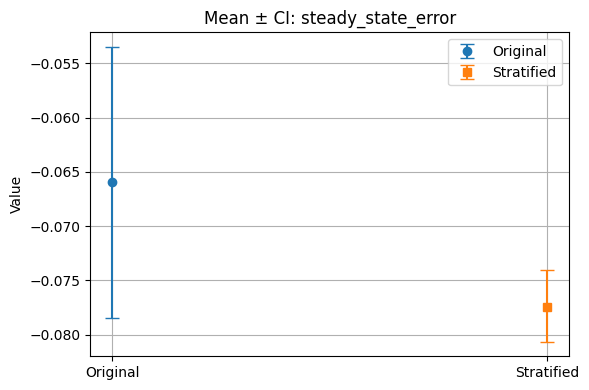

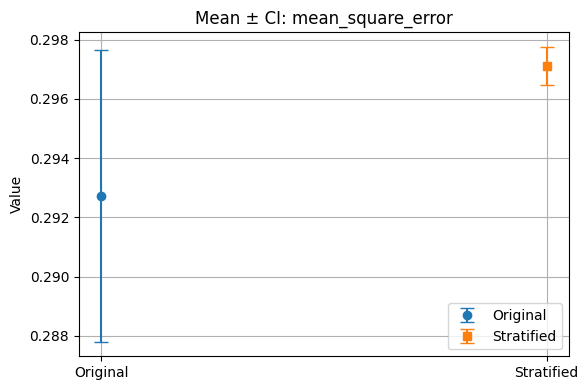

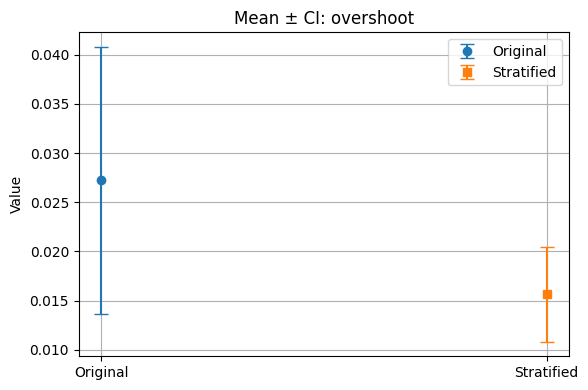

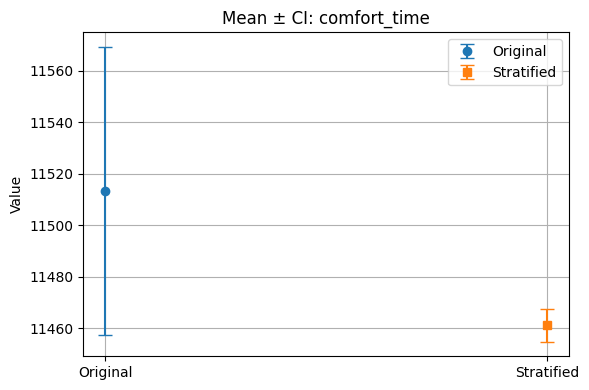

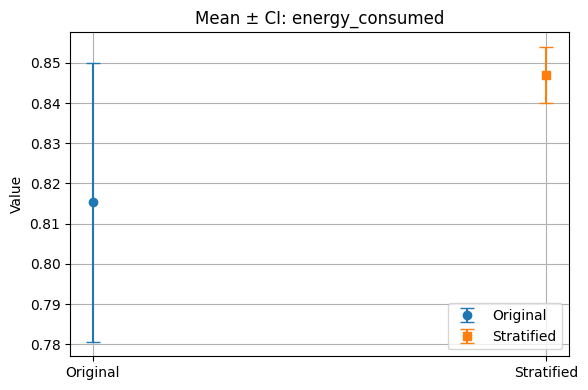

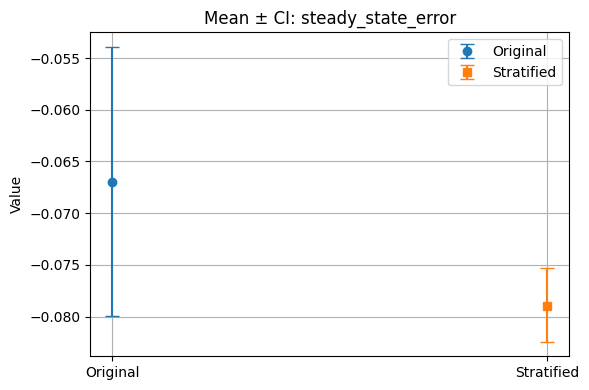

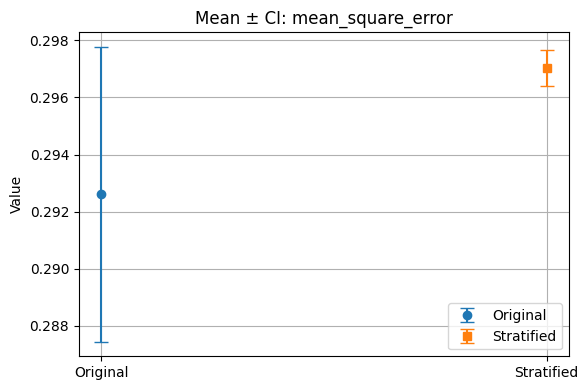

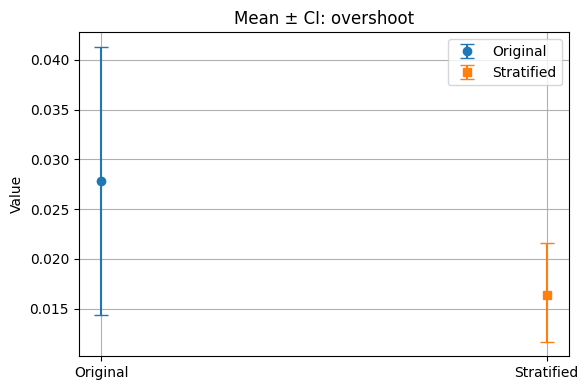

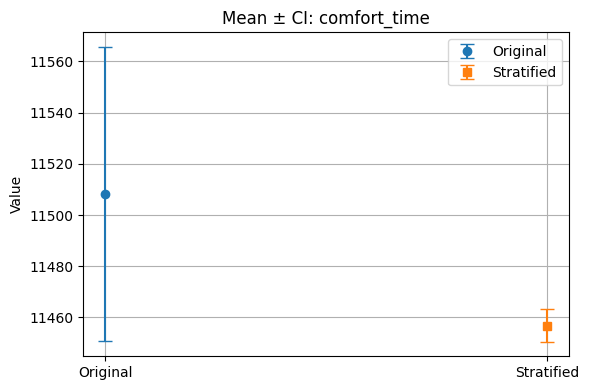

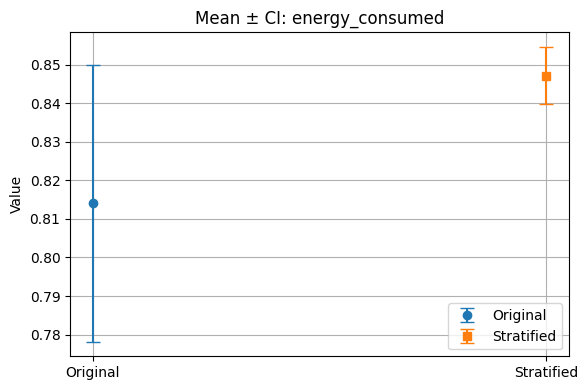

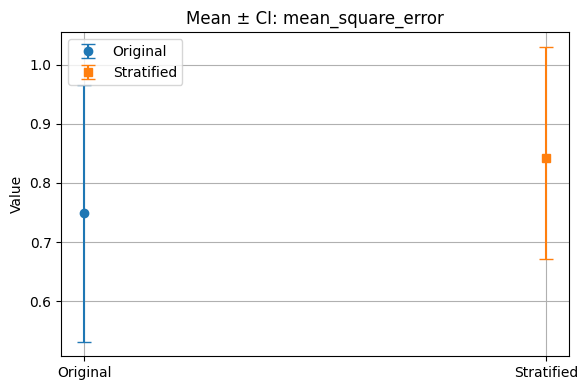

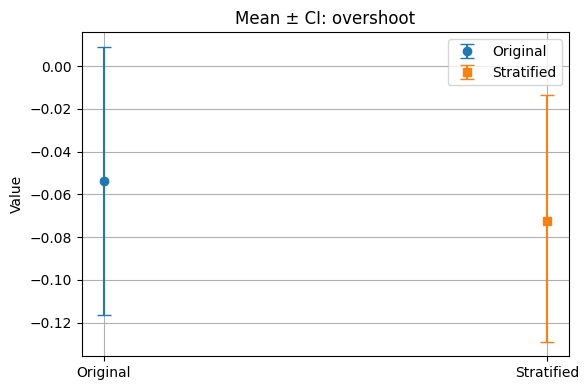

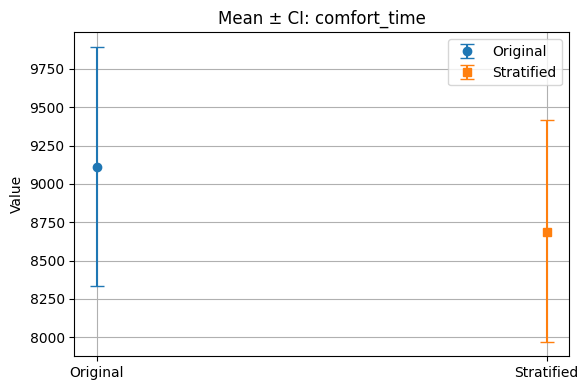

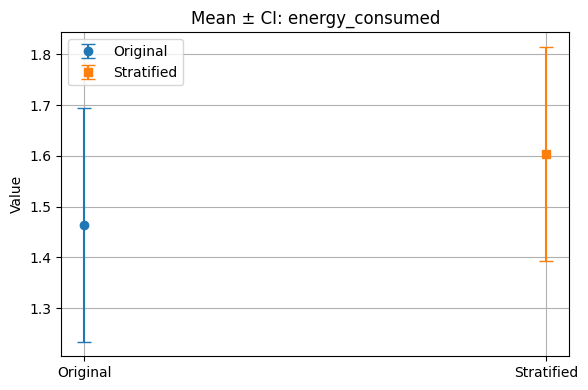

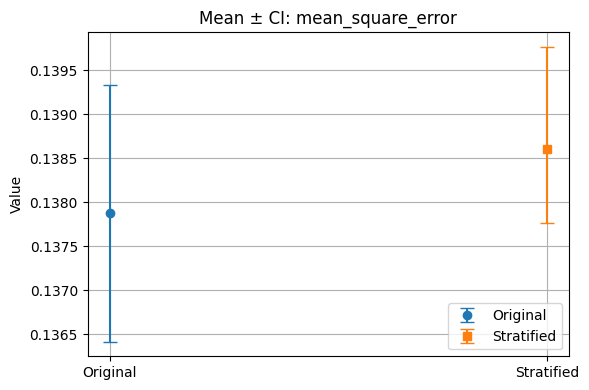

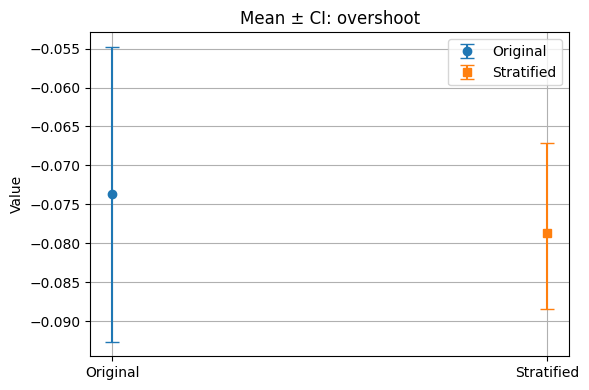

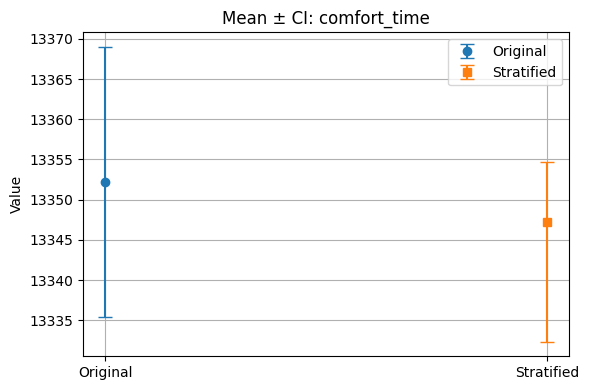

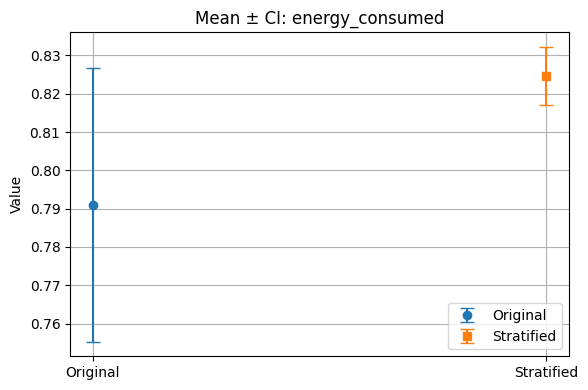

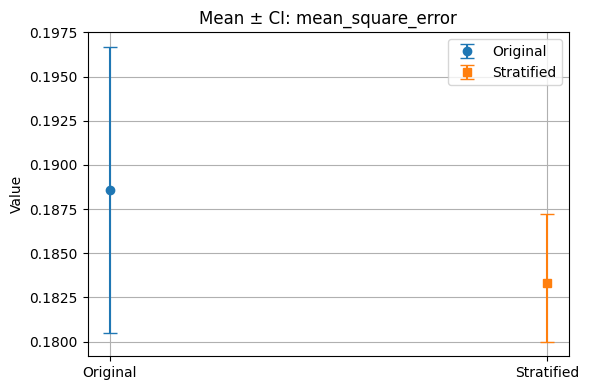

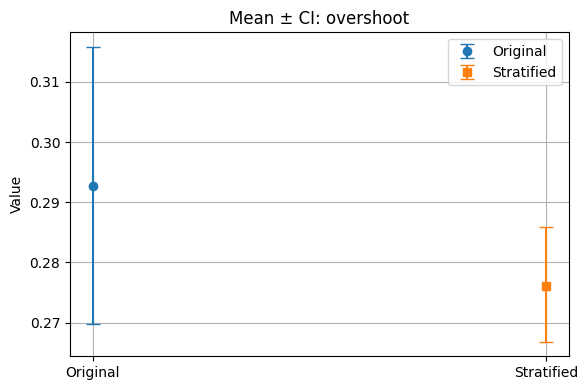

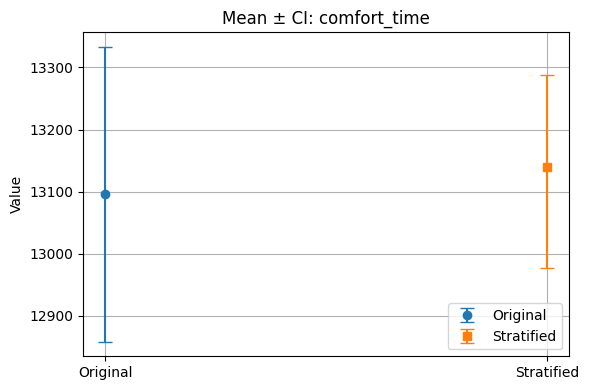

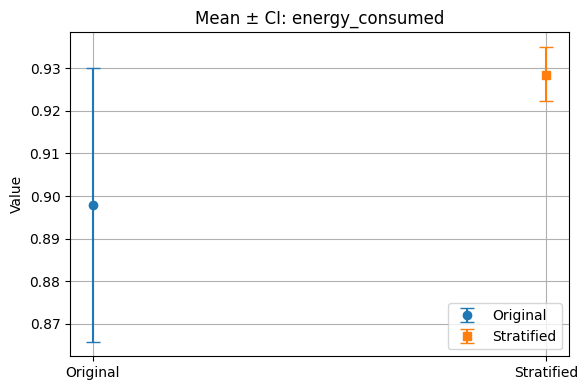

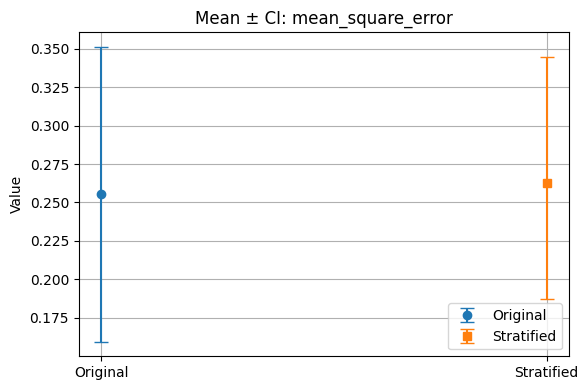

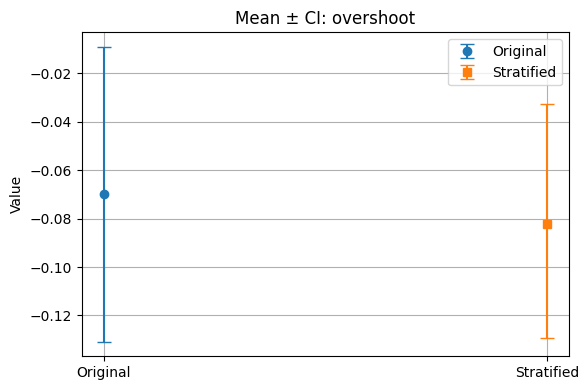

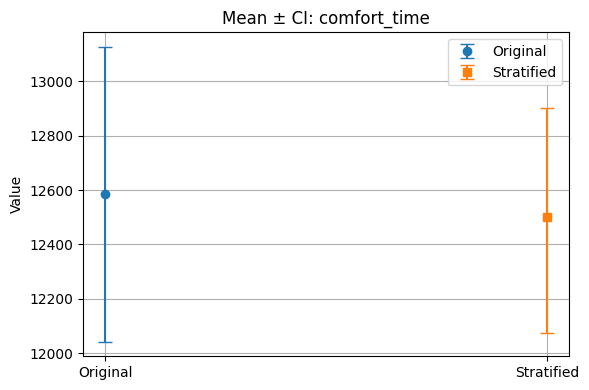

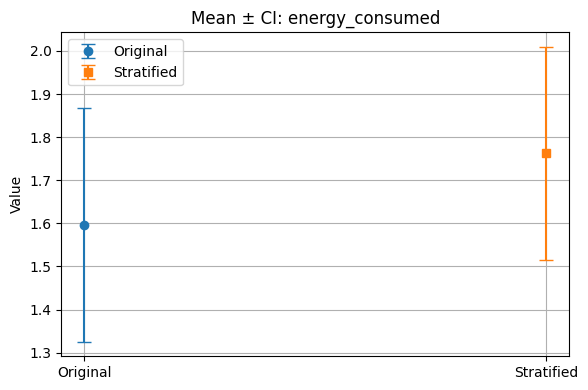

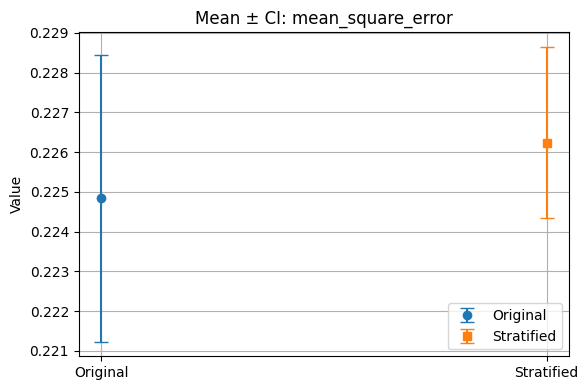

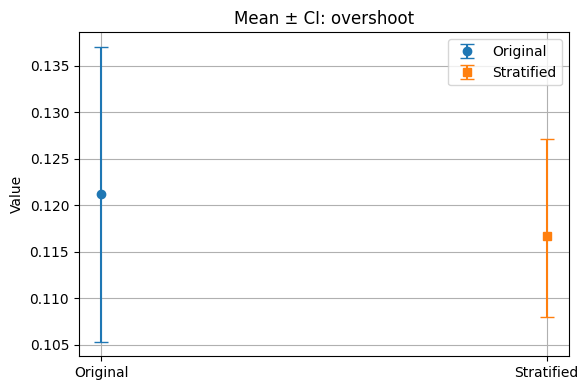

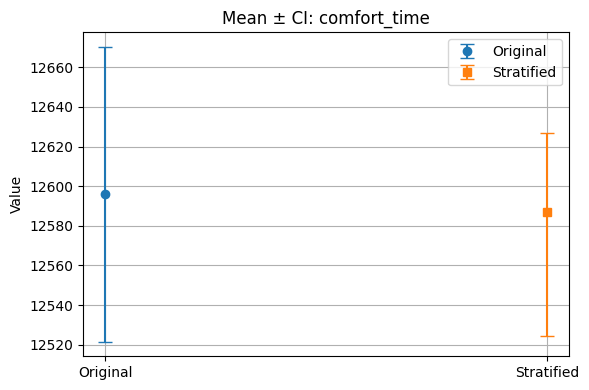

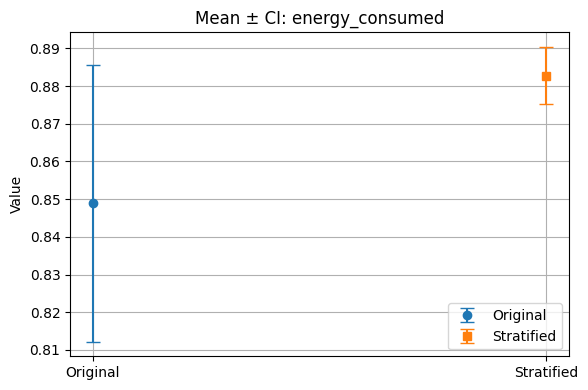

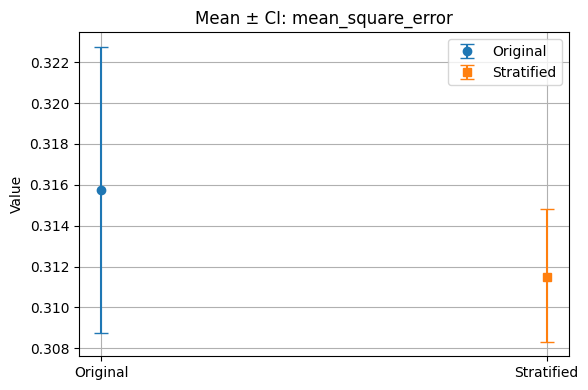

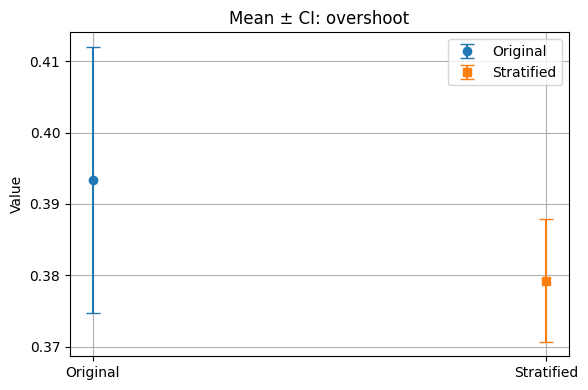

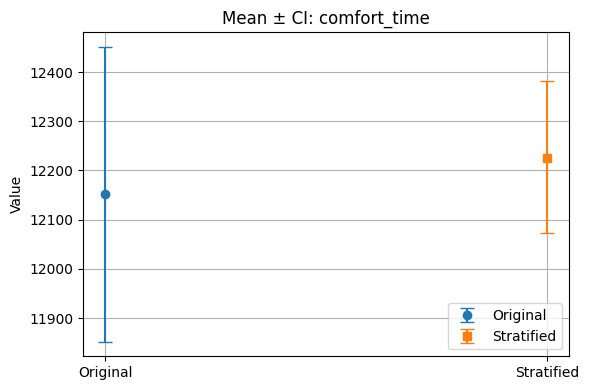

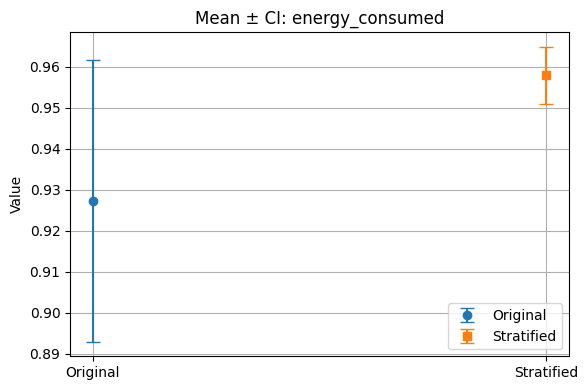

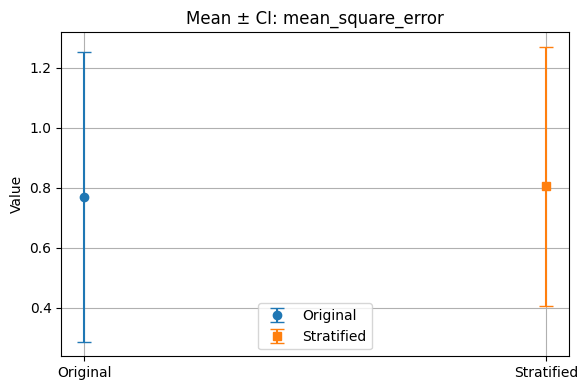

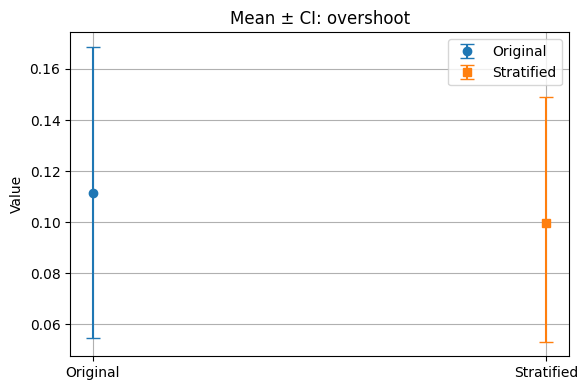

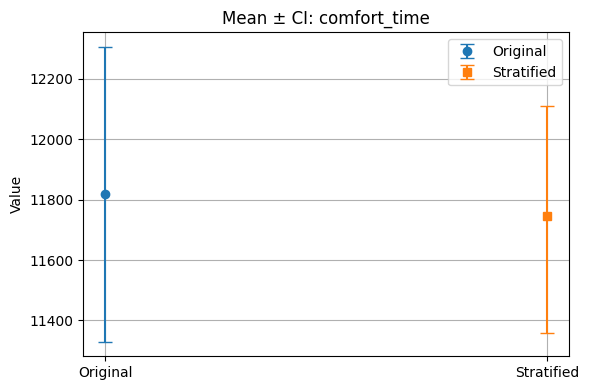

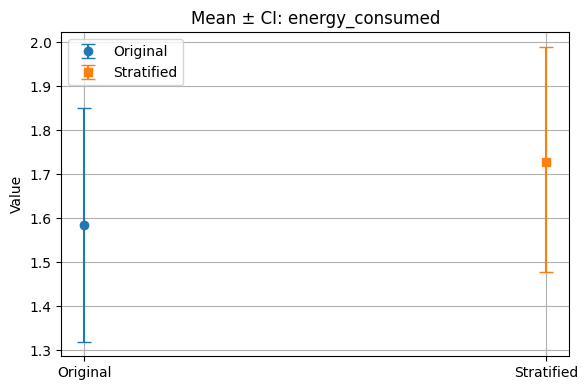

In [62]:
results_files = [
    "simulation_results/statistics/results_pid_nominal_aggregated.csv",
    "simulation_results/statistics/results_pid_with_noise_aggregated.csv",
    "simulation_results/statistics/results_pid_with_disturbances_aggregated.csv",
    "simulation_results/statistics/results_onoff_nominal_aggregated.csv",
    "simulation_results/statistics/results_onoff_with_noise_aggregated.csv",
    "simulation_results/statistics/results_onoff_with_disturbances_aggregated.csv",
    "simulation_results/statistics/results_fuzzy_nominal_aggregated.csv",
    "simulation_results/statistics/results_fuzzy_with_noise_aggregated.csv",
    "simulation_results/statistics/results_fuzzy_with_disturbances_aggregated.csv"
]

results_files_stratified = [
    "simulation_results/statistics/results_pid_nominal_aggregated_low_var.csv",
    "simulation_results/statistics/results_pid_with_noise_aggregated_low_var.csv",
    "simulation_results/statistics/results_pid_with_disturbances_aggregated_low_var.csv",
    "simulation_results/statistics/results_onoff_nominal_aggregated_low_var.csv",
    "simulation_results/statistics/results_onoff_with_noise_aggregated_low_var.csv",
    "simulation_results/statistics/results_onoff_with_disturbances_aggregated_low_var.csv",
    "simulation_results/statistics/results_fuzzy_nominal_aggregated_low_var.csv",
    "simulation_results/statistics/results_fuzzy_with_noise_aggregated_low_var.csv",
    "simulation_results/statistics/results_fuzzy_with_disturbances_aggregated_low_var.csv"
]

for original, stratified in zip(results_files, results_files_stratified):
    # Derive output directory name from file prefix
    base_name = os.path.basename(original).replace("_aggregated.csv", "")
    output_dir = f"plots/{base_name}"
    compare_and_plot(original, stratified, output_dir)
